# 第三回
今日は、全結合層を重ねたシンプルな深層学習ネットワークを用いて、手書き文字認識を行い、Kaggle に提出をしてみます。

今回、チャレンジするコンペは、[digit-recognizer](https://www.kaggle.com/c/digit-recognizer/) という常設のチュートリアルのようなものです。

データセットは[ここ](https://www.kaggle.com/c/digit-recognizer/data)から  
`../input/digit-recognizer/`にダウンロードしてください

![](../image/03.png)

## MLP
全結合層のみで構成されているやつ。

![](../image/02.png)

各層で、前の層から入力された重み付き線形和を計算し、次の層に流していきます。

## ReLU function
正規化線形関数  
近年の深層学習で、中間層の活性化関数として主に使われている。
$$ \mathrm{ReLU}(x) = \max(0, x)$$ で表される関数

## softmax function
活性化関数の1つ。  
特徴として
- 合計が1ですべて正　(確率として使える)
- sigmoid 関数の多変数拡張  
というものがある。sigmoid云々の話はPRMLにあるので、そちらを見てください。(PRML 上巻 p196)

名前の由来はソフト(滑らかな)マックス関数。該当クラスの確率が極端に高くなることから、多クラス分類の最後に使われることが多い。

定義式：  

$$ \mathrm{softmax}(\mathbb{a}) = \frac{\exp(a_k)}{\sum_j \exp(a_j)} $$

[参考](https://www.youtube.com/watch?v=5CwLT-IQB9E)

In [1]:
# モジュール読み込み
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

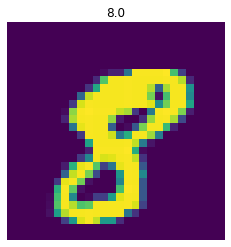

In [2]:
# データを読み込み
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype=np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
# ラベル(0-9)
targets_numpy = train.label.values
# 画像データセット (784x1に伸ばされている)
features_numpy = train.loc[:, train.columns != "label"].values/255

# 訓練用とテスト用にデータセットを分割
features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
# NumPy配列からTensorに変換
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
# NumPy配列からTensorに変換
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
# バッチサイズとエポック数を決定
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
# 画像とラベルの組をデータセット に変換
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
# ミニバッチ用のデータローダーを作成
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
# 画像を可視化
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [3]:
# 入力は28*28 の 784次元
input_dim = 28*28
# 出力は0-9 の10次元
output_dim = 10

In [4]:
# ネットワーク定義。今回は３層のMLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        # ネットワーク定義
        self.mlp = nn.Sequential(
            # 全結合層
            nn.Linear(input_dim, 256),
            # 活性化関数
            nn.ReLU(),
            # 全結合層
            nn.Linear(256, 256),
            # 活性化関数
            nn.ReLU(),
            # 全結合層
            nn.Linear(256, output_dim),
            # 活性化関数
            nn.Softmax()
        )
    def forward(self, x):
        return self.mlp(x)

In [5]:
# 評価関数
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    labels = []
    labels_preds= []
    for image, label in data_loader:
        image = image.to(device)
        label = label.to(device)
        with torch.no_grad():
            _, label_pred = net(image).max(1)
        labels.append(label)
        labels_preds.append(label_pred)

    labels = torch.cat(labels)
    labels_preds = torch.cat(labels_preds)

    # CSVファイルを吐き出さなければいけない
    # 推論したラベルはlabelsに入ってる。画像のIDは知らない

    acc = (labels == labels_preds).float().sum() / len(labels)
    return acc

In [6]:
# 訓練用の関数
def train_net(net, train_loader, test_loader, optimizer, loss_fn, n_iters=10, device="cpu"):
    # 
    train_losses = []
    train_acc = []
    val_acc = []
    for epoch in range(n_iters):
        running_loss = 0.
        net.train()
        n = 0
        srore = 0

        for i, (images, labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            label_pred = net(images)
            loss = loss_fn(label_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        # train_acc.append(n_a)
        val_acc.append(eval_net(net, test_loader, device))
        print(epoch, train_losses[-1], val_acc[-1], flush=True)

In [7]:
net = MLP(input_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)

# データをGPUに渡す
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)

# 訓練を実行
train_net(net, train_loader, test_loader, optimizer=optimizer, loss_fn=loss_fn, n_iters=20, device=device)


100%|██████████| 336/336 [00:00<00:00, 426.04it/s]0 1.6867121717049962 tensor(0.8298, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 544.72it/s]1 1.6012142548958461 tensor(0.9329, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 535.31it/s]2 1.5189935348573185 tensor(0.9494, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 529.94it/s]3 1.503878938300269 tensor(0.9585, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 538.10it/s]4 1.4963589342577117 tensor(0.9590, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 525.98it/s]
5 1.4913580389249892 tensor(0.9540, device='cuda:0')
100%|██████████| 336/336 [00:00<00:00, 532.93it/s]6 1.4870836610595386 tensor(0.9619, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 530.57it/s]7 1.4849073372426487 tensor(0.9629, device='cuda:0')

100%|██████████| 336/336 [00:00<00:00, 524.23it/s]
8 1.4832288317737126 tensor(0.9637, device='cuda:0')
100%|██████████| 336/336 [00:00<00:00, 536.88it/s]9 1.47998788101

In [8]:
# パラメータを保存
torch.save(net.state_dict(), r'../param/model.prm')

In [9]:
# 検証用データセットを作成
test = pd.read_csv(r"../input/digit-recognizer/test.csv", dtype=np.float32)

# データを正規化し、Tensorを作る
features_test = test.values/255
features_test = torch.from_numpy(features_test)
test = TensorDataset(features_test)

# データローダを作成
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [10]:
# 推論用の関数
def prediction(data_loader, device='cpu'):
    # パラメータの読み込み
    net.load_state_dict(torch.load(r'../param/model.prm', map_location=device))
    net.eval()
    test_pred = torch.LongTensor()

    for images in data_loader:
        images = images[0].to(device)
        output = net(images)
        _, pred = output.cpu().data.max(1, keepdim=True)
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [11]:
# 推論を行う
test_pred = prediction(test_loader, device=device)

# データの整形
out_df = pd.DataFrame(np.c_[np.arange(1, len(test)+1)[:,None],
    test_pred.numpy()], columns=['ImageId', 'Label'])

# 出力
out_df.head()
out_df.to_csv('submission.csv', index=False)